In [1]:
from PIL import Image
import numpy as np
import cv2
import os
import keras.preprocessing.image as kpi
import tensorflow as tf
import tensorflow.keras.layers as tfl
np.random.seed(1)

In [2]:
def generate_labels(path):
  li = []
  for filename in os.listdir(path):
    li.append(filename[0])
  return np.array(li)


In [3]:
data_augmentation = tf.keras.Sequential([
  tfl.experimental.preprocessing.RandomRotation(0.2),
  tfl.experimental.preprocessing.RandomCrop(224,224)
])

resize_and_rescale_250 = tf.keras.Sequential([
  tfl.experimental.preprocessing.Resizing(250, 250),
  tfl.experimental.preprocessing.Rescaling(1./255)
])
resize_and_rescale_224 = tf.keras.Sequential([
  tfl.experimental.preprocessing.Resizing(224, 224),
  tfl.experimental.preprocessing.Rescaling(1./255)
])

2021-10-03 12:09:26.885063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 12:09:26.949311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-10-03 12:09:26.949361: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-03 12:09:27.035086: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [6]:
def load_images_from_folder(folder,size):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_UNCHANGED)
        
        if img is not None:
            img = resize_and_rescale_250(img) if size == 250 else resize_and_rescale_224(img)
            images.append(img)
    return np.array(images)

no_trash = load_images_from_folder("Data/No_trash",250)
trash = load_images_from_folder("Data/Trash",250)
no = load_images_from_folder("Data/No_trash",224)
yes = load_images_from_folder("Data/Trash",224)



In [7]:
aug1 = []
aug0 = []
for img in trash:
  aug1.append(data_augmentation(img))
for img in no_trash:
  aug0.append(data_augmentation(img))
aug1 = np.array(aug1)
aug0 = np.array(aug0)

In [8]:
nos = np.concatenate((aug0,no), axis=0)
yes = np.concatenate((aug1,yes))
data = np.concatenate((nos,yes))
labels = np.array([0 for i in nos]+[1 for i in yes])

In [9]:
data.shape

(596, 224, 224, 3)

In [10]:
from keras.applications.vgg16 import VGG16

In [11]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
	layer.trainable = False

58900480/58889256 [==============================] - 6s 0us/step


In [12]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
flat1 = tfl.Flatten()(model.layers[-1].output)
class1 = tfl.Dense(1024, activation='relu')(flat1)
output = tfl.Dense(1, activation='sigmoid')(class1)
model = tf.keras.Model(inputs=model.inputs, outputs=output)

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
model.fit(data,labels,batch_size = 64,epochs =4, validation_split=0.2)


2021-10-03 12:13:33.658224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
8/8 [==============================] - 49s 6s/step - loss: 3.2053 - accuracy: 0.7521 - val_loss: 0.5232 - val_accuracy: 0.8833
Epoch 2/4
8/8 [==============================] - 50s 6s/step - loss: 0.1380 - accuracy: 0.9706 - val_loss: 2.7231 - val_accuracy: 0.7667
Epoch 3/4
8/8 [==============================] - 50s 6s/step - loss: 0.1169 - accuracy: 0.9727 - val_loss: 0.5135 - val_accuracy: 0.9083
Epoch 4/4
8/8 [==============================] - 52s 7s/step - loss: 0.0470 - accuracy: 0.9832 - val_loss: 0.7730 - val_accuracy: 0.8417


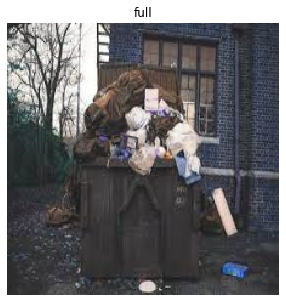

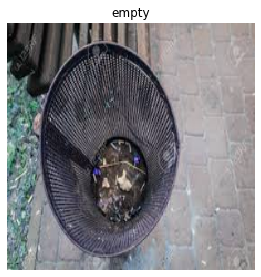

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
img2 = np.array(resize_and_rescale_224(cv2.imread("Data/No_trash/0_08.jpeg",cv2.IMREAD_UNCHANGED)))
img1 = np.array(resize_and_rescale_224(cv2.imread("Data/Trash/1_015.jpeg",cv2.IMREAD_UNCHANGED)))
fig.add_subplot(1, 1, 1)
plt.imshow(img1, interpolation='nearest')
img1 = img1.reshape((1,224,224,3))
features = model.predict(img1)
label = "empty" if features<0.5 else "full"
plt.title(label)
plt.axis("off")
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 1, 1)
plt.imshow(img2, interpolation='nearest')
img2 = img2.reshape((1,224,224,3))
features = model.predict(img2)
label = "empty" if features<0.5 else "full"
plt.title(label)
plt.axis("off")
plt.show()